# 🧠 Beginner-Friendly Regression Pipeline: Predicting Medical Insurance Costs

Welcome! In this tutorial-style notebook we will build, explain, and evaluate a complete supervised machine learning pipeline that predicts individual medical insurance costs.


### 🩺 Dataset at a glance
- **Source**: [Medical Cost Personal Dataset](https://github.com/stedy/Machine-Learning-with-R-datasets) collected to model U.S. individual medical insurance charges.
- **Goal**: Predict the `charges` a person pays for medical insurance based on demographics and personal health indicators.

### 📈 What is regression?
Regression is a supervised learning technique used to predict continuous numeric values. In our case, we will learn a function that maps a person's characteristics (age, BMI, smoking status, etc.) to an estimated insurance charge.

Understanding regression helps us:
- quantify how features influence a numeric outcome;
- forecast future values for planning or pricing;
- evaluate how well a model generalizes to unseen people.


### 🛠️ Pipeline roadmap
We will follow these steps:
1. Inspect and understand the data.
2. Explore patterns visually and statistically.
3. Prepare features via encoding and scaling.
4. Split the data into training and testing sets.
5. Train and tune Linear, Ridge, Lasso, and Elastic Net regressors.
6. Evaluate performance with multiple metrics and diagnostics.
7. Interpret the models and identify impactful features.
8. Persist the best model and use it for new predictions.

Along the way, you will see explanations before each code cell to keep the narrative beginner-friendly. 🚀


### ⚙️ Setup and imports
Let's load the libraries used throughout the notebook.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import dump, load

sns.set_theme(style="whitegrid", palette="deep")


### 📥 Load the medical cost dataset
We will load the CSV file directly from GitHub (no manual download needed). After loading, we'll inspect the first few rows and overall shape.


In [2]:
DATA_URL = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"

df = pd.read_csv(DATA_URL)

print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 🧾 Column descriptions
- `age`: Age of the primary beneficiary (years).
- `sex`: Gender of the beneficiary (`male`, `female`).
- `bmi`: Body Mass Index, a measure of body fat based on height and weight.
- `children`: Number of dependents covered by the insurance plan.
- `smoker`: Whether the beneficiary is a smoker (`yes`, `no`).
- `region`: Residential area in the U.S. (`northeast`, `northwest`, `southeast`, `southwest`).
- `charges`: Medical insurance cost billed to the individual (target variable).


### 🔎 Data structure summary
Let's look at basic information, data types, and summary statistics to understand scales and spot potential issues.


In [3]:
df.info()
display(df.describe().T)
display(df.describe(include="object").T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


## 📊 Exploratory Data Analysis (EDA)
We start by checking missing values and overall distributions.


In [4]:
missing_values = df.isna().sum()
missing_summary = pd.DataFrame({
    'missing_count': missing_values,
    'missing_%': (missing_values / len(df)) * 100
})
display(missing_summary)


,missing_count,missing_%
age,0,0.0
sex,0,0.0
bmi,0,0.0
children,0,0.0
smoker,0,0.0
region,0,0.0
charges,0,0.0


### 🪄 Distribution of numeric features
Histograms help us spot skewness and spread for each numeric column.


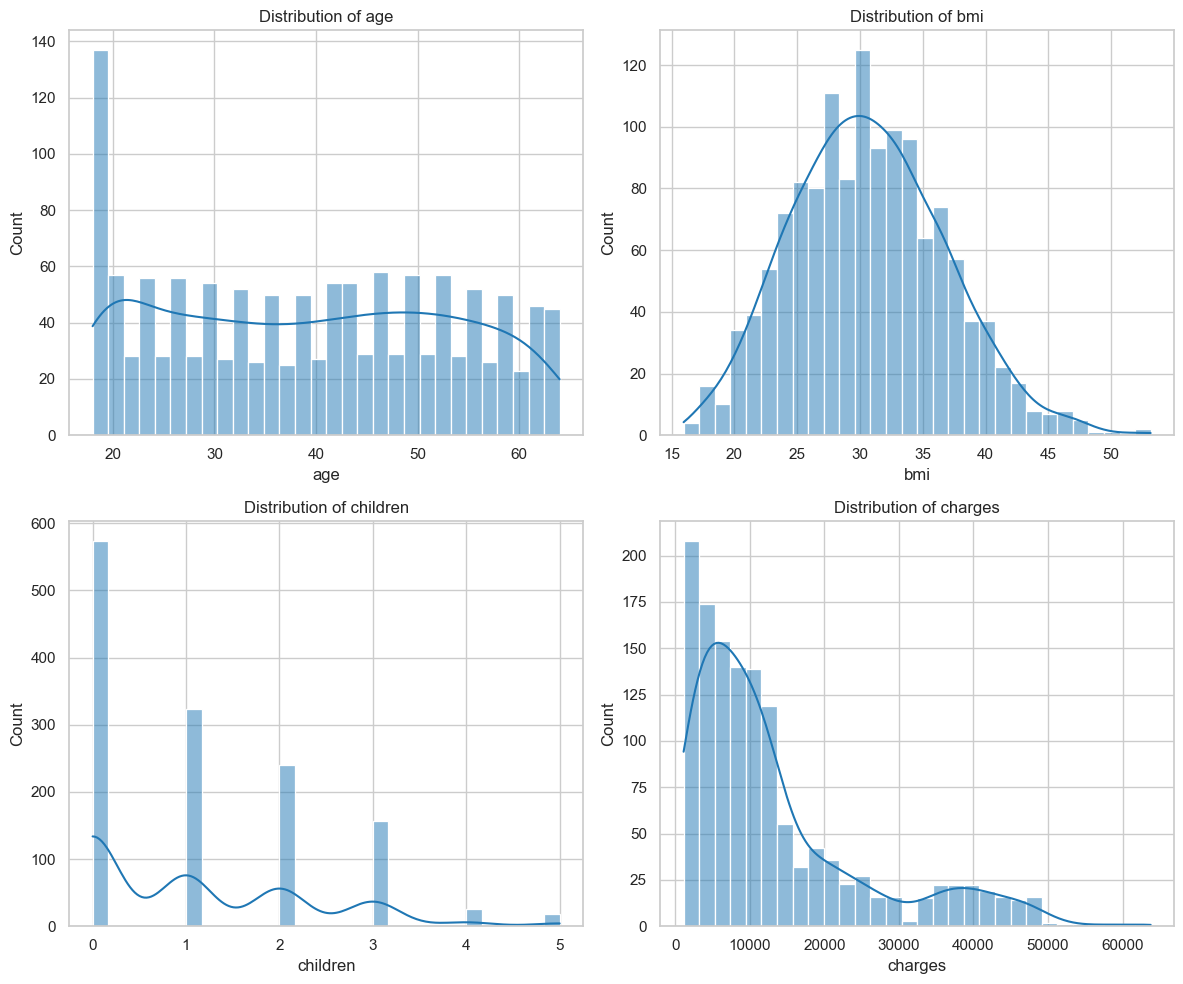

In [5]:
numeric_cols = ['age', 'bmi', 'children', 'charges']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=ax, color="#1f77b4")
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


### 🔍 Relationships between features and charges
Scatter plots and box plots reveal how charges change across numeric and categorical features.


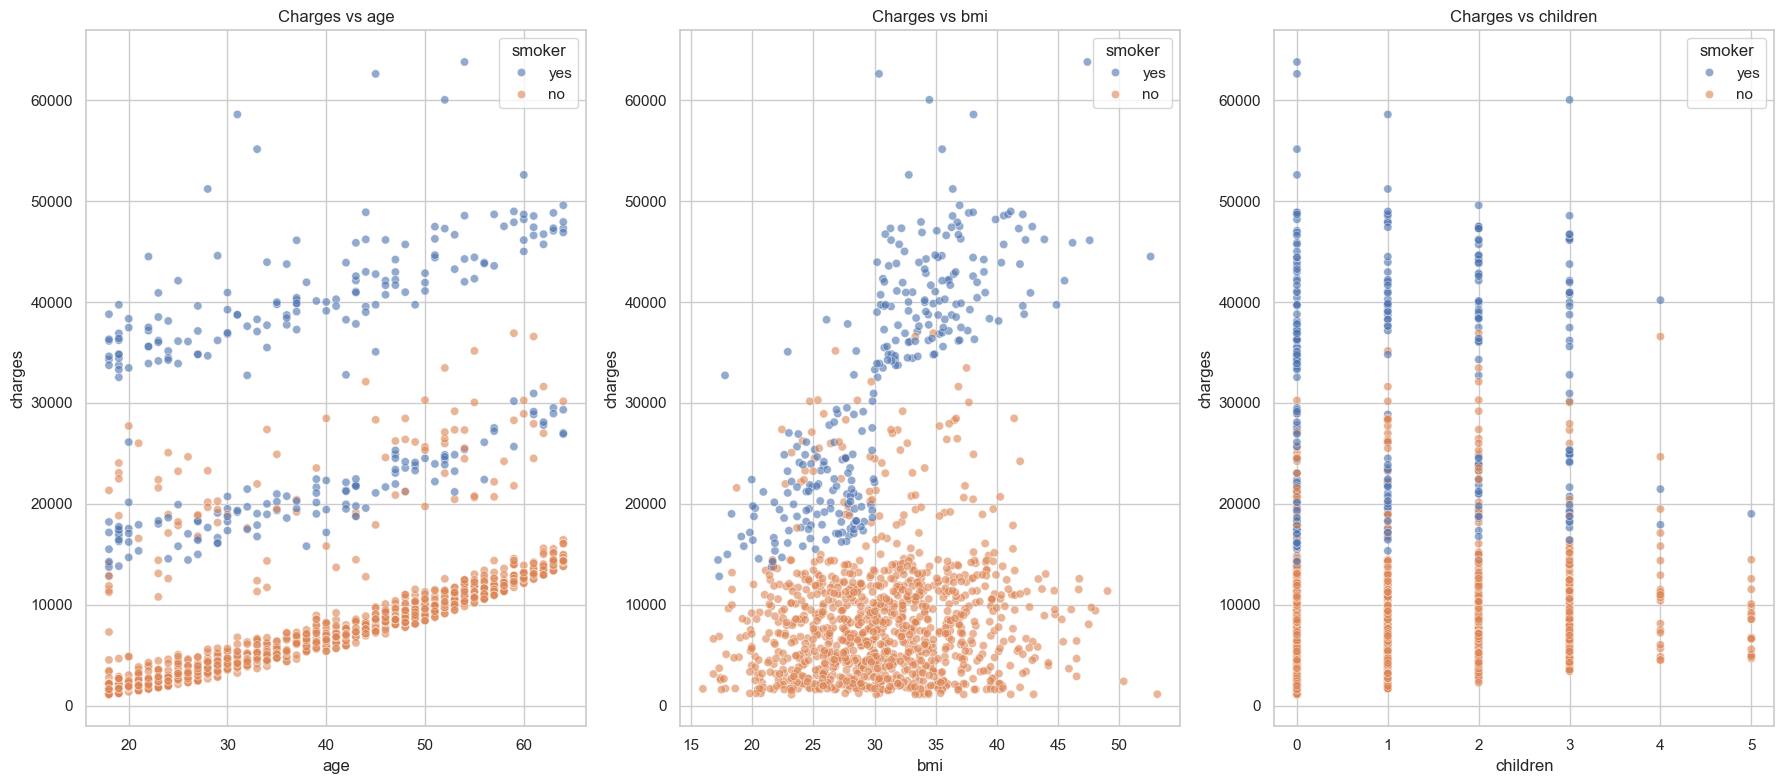

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
comparison_features = ['age', 'bmi', 'children']

for ax, feature in zip(axes, comparison_features):
    sns.scatterplot(data=df, x=feature, y='charges', hue='smoker', alpha=0.6, ax=ax)
    ax.set_title(f'Charges vs {feature}')
    ax.set_ylabel('charges')

plt.tight_layout()
plt.show()


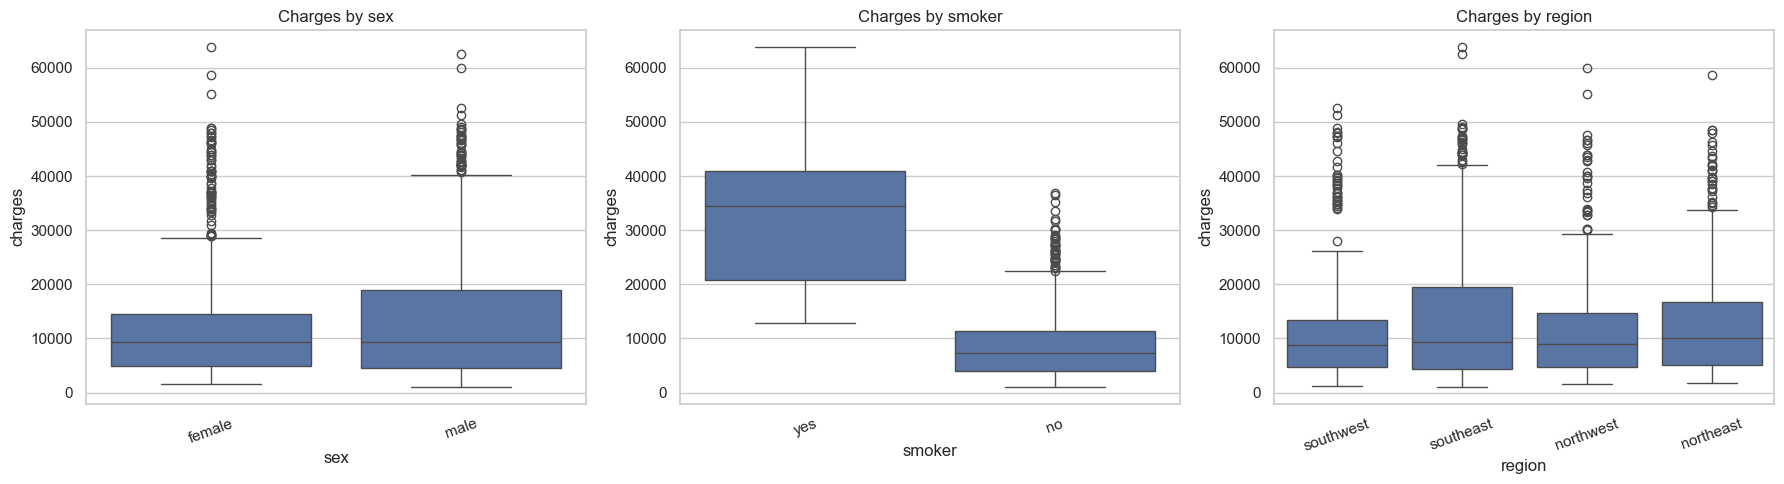

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
categorical_cols = ['sex', 'smoker', 'region']

for ax, col in zip(axes, categorical_cols):
    sns.boxplot(data=df, x=col, y='charges', ax=ax)
    ax.set_title(f'Charges by {col}')
    ax.set_ylabel('charges')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()


### 🧩 Pairwise relationships and smoker effect
Pair plots allow us to inspect interactions between numeric features and see how smoker status alters charges.


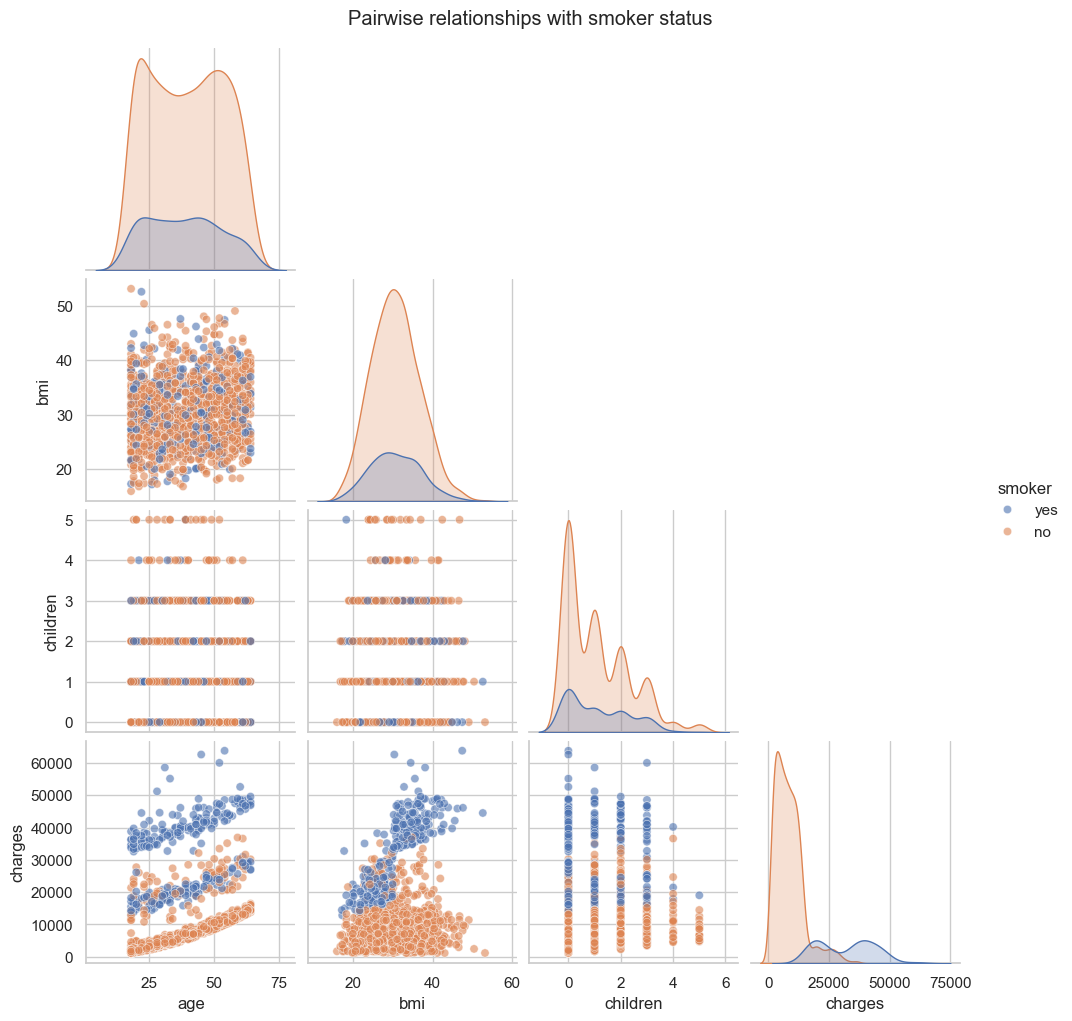

In [8]:
pairplot = sns.pairplot(
    df,
    vars=['age', 'bmi', 'children', 'charges'],
    hue='smoker',
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.6}
)
pairplot.fig.suptitle('Pairwise relationships with smoker status', y=1.02)
plt.show()


### 🔥 Correlation heatmap
We examine how strongly numeric variables move together.


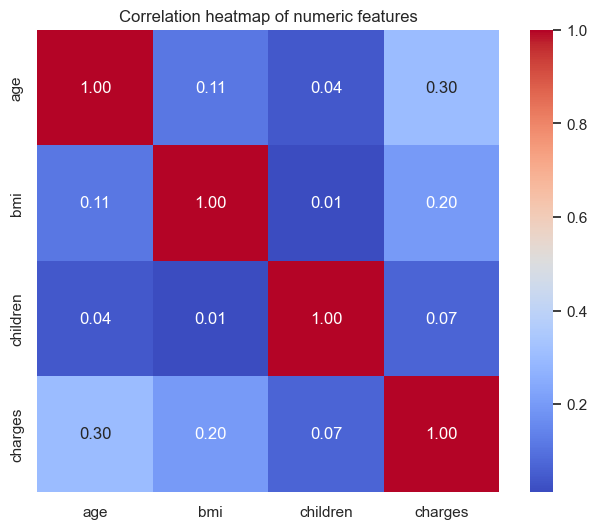

In [9]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation heatmap of numeric features')
plt.show()


### ✨ Key EDA takeaways
- Charges increase notably with age and smoking status.
- Smokers tend to have much higher and more variable charges than non-smokers.
- BMI shows a positive, slightly non-linear relationship with charges.
- No missing values are present, so we can focus on encoding and scaling.


## ⚙️ Feature engineering and preprocessing
We prepare features for modeling by encoding categorical columns and scaling numeric ones.


### 🧮 Checking target skewness and optional log transform
If a target is strongly skewed, taking the logarithm can make modeling easier. We'll compare distributions but keep the original `charges` for this walkthrough.


Original charges skewness: 1.52
Log-transformed charges skewness: -0.09


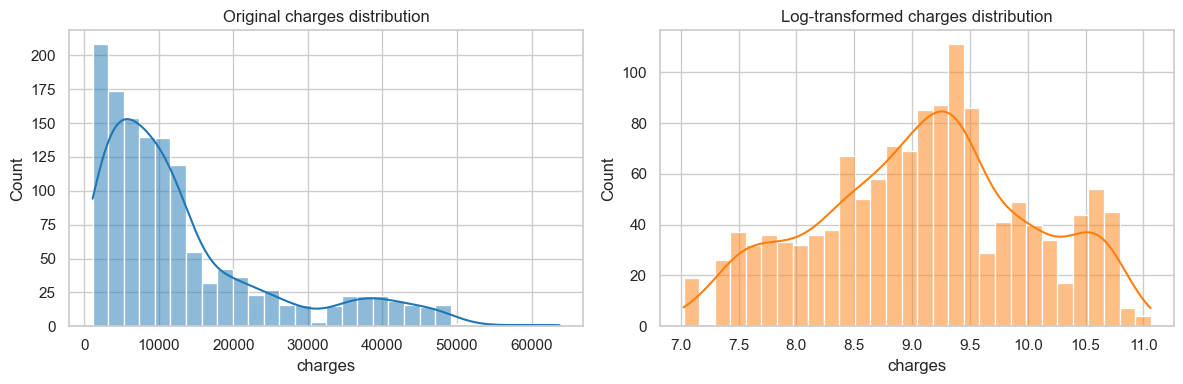

In [10]:
charges_skew = df['charges'].skew()
charges_log = np.log1p(df['charges'])
log_skew = charges_log.skew()

print(f'Original charges skewness: {charges_skew:.2f}')
print(f'Log-transformed charges skewness: {log_skew:.2f}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['charges'], bins=30, kde=True, ax=axes[0], color='#1f77b4')
axes[0].set_title('Original charges distribution')
sns.histplot(charges_log, bins=30, kde=True, ax=axes[1], color='#ff7f0e')
axes[1].set_title('Log-transformed charges distribution')
plt.tight_layout()
plt.show()


The log transform reduces skewness, but we will keep predictions in the original dollar scale for interpretability.


In [11]:
FEATURE_COLUMNS = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
TARGET_COLUMN = 'charges'

X = df[FEATURE_COLUMNS].copy()
y = df[TARGET_COLUMN].copy()

display(X.head())


,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


### ✂️ Train-test split
We reserve 20% of the data for testing to evaluate generalization. Setting a `random_state` makes the split reproducible.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training set size: {X_train.shape[0]} rows')
print(f'Test set size: {X_test.shape[0]} rows')


Training set size: 1070 rows
Test set size: 268 rows


### 🧱 Preprocessing pipeline
We'll scale numeric columns and one-hot encode categorical columns using a `ColumnTransformer`.


In [13]:
categorical_features = ['sex', 'smoker', 'region']
numeric_features = ['age', 'bmi', 'children']

def create_preprocessor():
    """Builds a ColumnTransformer for scaling and encoding."""
    return ColumnTransformer(
        transformers=[
            ('numeric', StandardScaler(), numeric_features),
            ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='drop',
        sparse_threshold=0
    )

demo_preprocessor = create_preprocessor()
demo_preprocessor.fit(X_train)
demo_feature_names = demo_preprocessor.get_feature_names_out()
prepared_preview = demo_preprocessor.transform(X_train.iloc[:5])
prepared_df = pd.DataFrame(prepared_preview, columns=demo_feature_names)
display(prepared_df.head())


,numeric__age,numeric__bmi,numeric__children,categorical__sex_female,categorical__sex_male,categorical__smoker_no,categorical__smoker_yes,categorical__region_northeast,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest
0,0.472227,-1.756525,0.734336,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.543313,-1.033082,-0.911192,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.898745,-0.943687,-0.911192,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.025379,0.622393,3.202629,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.040918,-1.504893,1.557100,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## 🤖 Model training with regularization
We will train four linear models. Regularization (Ridge, Lasso, Elastic Net) helps prevent overfitting by penalizing large coefficients.


In [14]:
def adjusted_r2_score(y_true, y_pred, n_features):
    """Compute adjusted R² to account for feature count."""
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    denominator = max(n - n_features - 1, 1)
    return 1 - (1 - r2) * (n - 1) / denominator

def get_feature_importance(model):
    """Extract feature names and coefficients from a fitted pipeline."""
    preprocess = model.named_steps['preprocess']
    feature_names = preprocess.get_feature_names_out()
    coefficients = model.named_steps['regressor'].coef_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    importance_df['Absolute Coefficient'] = importance_df['Coefficient'].abs()
    return importance_df.sort_values('Absolute Coefficient', ascending=False)


In [15]:
models = {
    'Linear Regression': (
        LinearRegression(),
        {'regressor__fit_intercept': [True, False]}
    ),
    'Ridge Regression': (
        Ridge(),
        {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
    ),
    'Lasso Regression': (
        Lasso(max_iter=10000),
        {'regressor__alpha': [0.001, 0.01, 0.1, 1.0]}
    ),
    'Elastic Net Regression': (
        ElasticNet(max_iter=10000),
        {
            'regressor__alpha': [0.001, 0.01, 0.1, 1.0],
            'regressor__l1_ratio': [0.2, 0.5, 0.8]
        }
    )
}

evaluation_records = []
tuning_records = []
predictions_store = {}
residuals_store = {}
best_models = {}

for name, (estimator, param_grid) in models.items():
    pipeline = Pipeline([
        ('preprocess', create_preprocessor()),
        ('regressor', estimator)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = time.time() - start_time

    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)
    predictions_store[name] = y_pred
    residuals_store[name] = y_test - y_pred

    transformed_test = best_model.named_steps['preprocess'].transform(X_test)
    n_features = transformed_test.shape[1]

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2_score(y_test, y_pred, n_features)

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

    evaluation_records.append({
        'Model': name,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'RMSE': rmse,
        'MAE': mae,
        'CV R² (mean)': cv_scores.mean(),
        'CV R² (std)': cv_scores.std(),
        'Training Time (s)': fit_time
    })

    tuning_records.append({
        'Model': name,
        'Best Hyperparameters': grid_search.best_params_
    })

    print(f"{name} best params: {grid_search.best_params_}")
    print(f"Training time: {fit_time:.2f} seconds\n")


Linear Regression best params: {'regressor__fit_intercept': True}
Training time: 12.20 seconds

Ridge Regression best params: {'regressor__alpha': 1.0}
Training time: 0.19 seconds

Lasso Regression best params: {'regressor__alpha': 1.0}
Training time: 0.35 seconds

Elastic Net Regression best params: {'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.2}
Training time: 0.63 seconds



### 📋 Evaluation summary
We compare models using multiple metrics. Higher R² and lower RMSE/MAE indicate better performance.


In [16]:
metrics_df = pd.DataFrame(evaluation_records)
metrics_pretty = metrics_df.copy()
metrics_pretty[['R²', 'Adjusted R²', 'CV R² (mean)', 'CV R² (std)']] = metrics_pretty[['R²', 'Adjusted R²', 'CV R² (mean)', 'CV R² (std)']].round(3)
metrics_pretty[['RMSE', 'MAE', 'Training Time (s)']] = metrics_pretty[['RMSE', 'MAE', 'Training Time (s)']].round(2)
display(metrics_pretty.sort_values('RMSE'))

tuning_df = pd.DataFrame(tuning_records)
display(tuning_df)


,Model,R²,Adjusted R²,RMSE,MAE,CV R² (mean),CV R² (std),Training Time (s)
0,Linear Regression,0.784,0.774,33596915.85,4181.19,0.733,0.049,12.20
2,Lasso Regression,0.784,0.774,33605838.11,4182.08,0.733,0.049,0.35
3,Elastic Net Regression,0.783,0.774,33616820.31,4186.08,0.733,0.049,0.63
1,Ridge Regression,0.783,0.774,33620268.92,4186.91,0.733,0.049,0.19


,Model,Best Hyperparameters
0,Linear Regression,{'regressor__fit_intercept': True}
1,Ridge Regression,{'regressor__alpha': 1.0}
2,Lasso Regression,{'regressor__alpha': 1.0}
3,Elastic Net Regression,"{'regressor__alpha': 0.001, 'regressor__l1_rat..."


### 📈 Predicted vs. actual charges
A perfect model would align with the dashed diagonal line. Deviations show prediction errors.


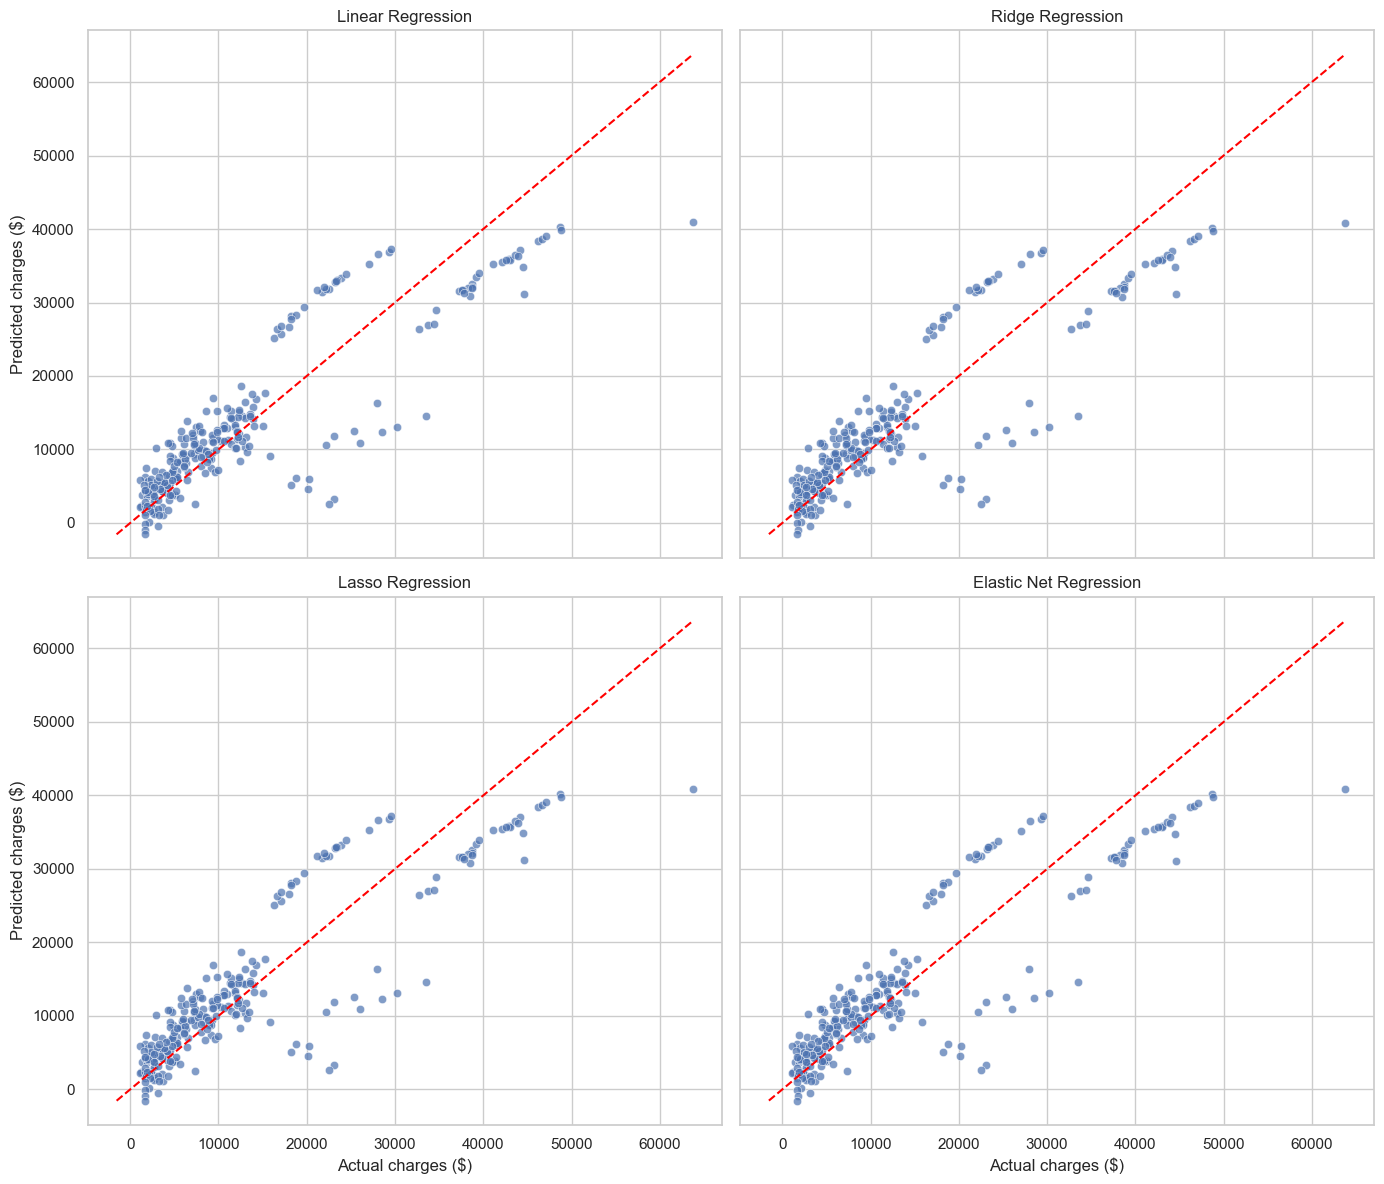

In [17]:
model_names = list(predictions_store.keys())
actual_values = y_test.values

fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, name in zip(axes, model_names):
    preds = predictions_store[name]
    sns.scatterplot(x=actual_values, y=preds, ax=ax, alpha=0.7)
    min_val = min(actual_values.min(), preds.min())
    max_val = max(actual_values.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red')
    ax.set_title(name)
    ax.set_xlabel('Actual charges ($)')
    ax.set_ylabel('Predicted charges ($)')

plt.tight_layout()
plt.show()


### 🪛 Residual analysis
Residuals (actual − predicted) should hover around zero without clear patterns.


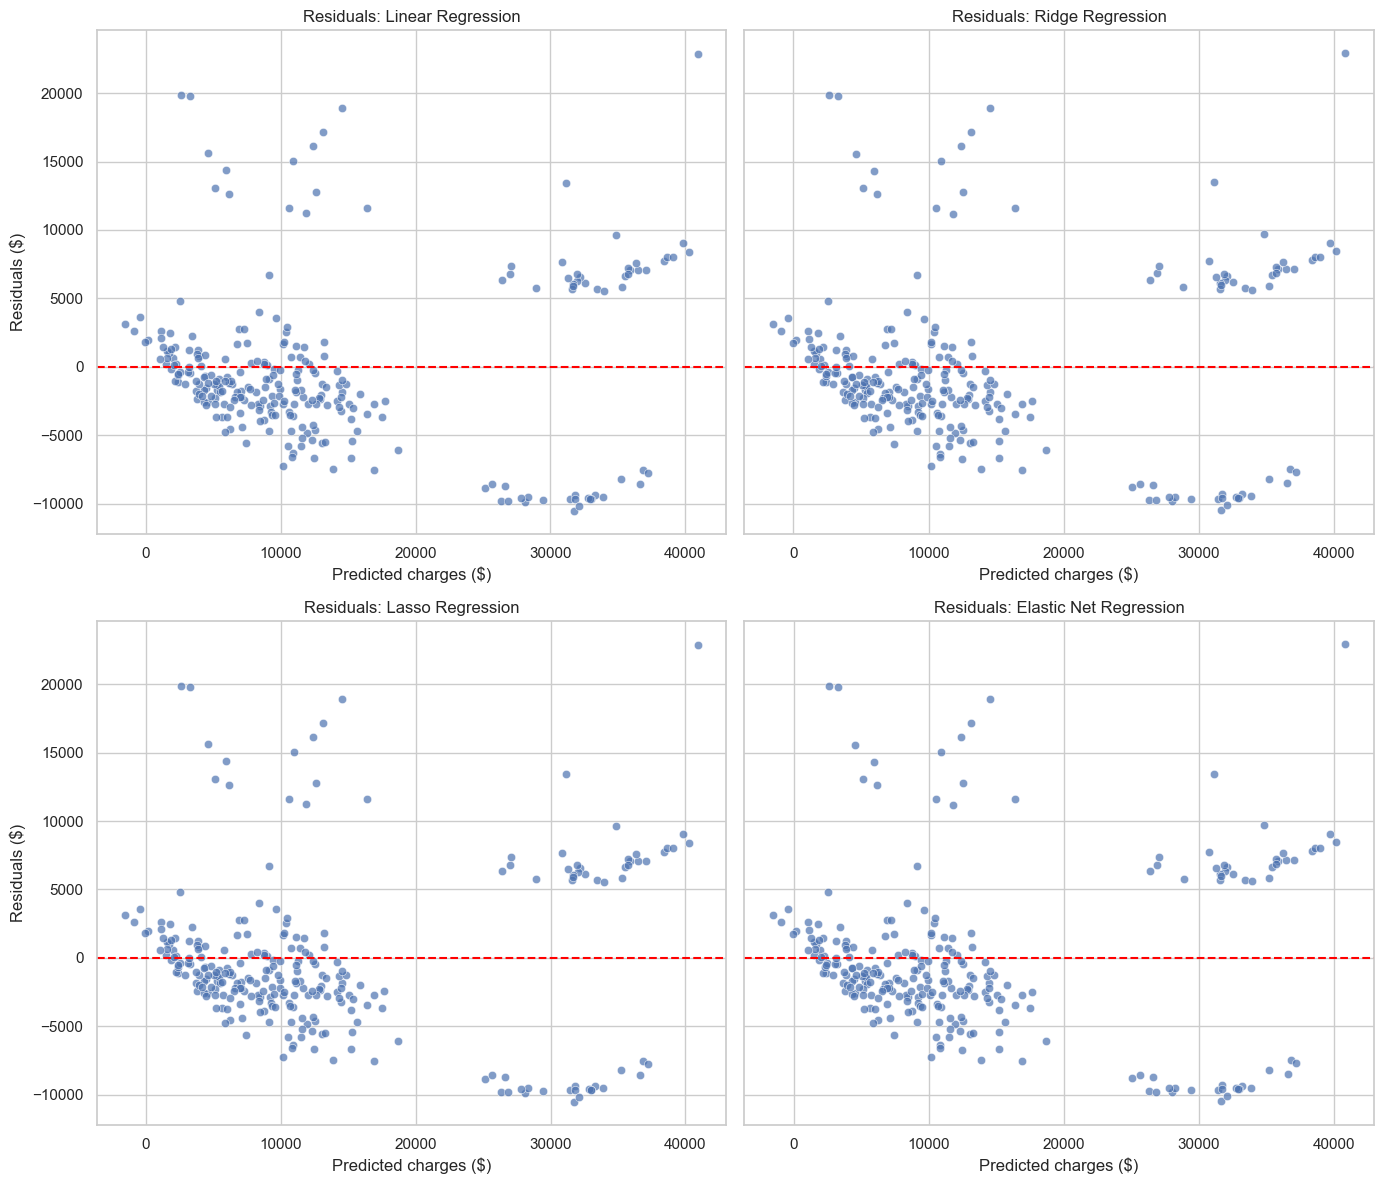

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

for ax, name in zip(axes, model_names):
    residuals = residuals_store[name]
    sns.scatterplot(x=predictions_store[name], y=residuals, ax=ax, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f'Residuals: {name}')
    ax.set_xlabel('Predicted charges ($)')
    ax.set_ylabel('Residuals ($)')

plt.tight_layout()
plt.show()


## 🔍 Model interpretation
We inspect coefficients to understand which features drive predictions. Larger absolute values indicate stronger influence.


In [19]:
linear_coeffs = get_feature_importance(best_models['Linear Regression'])
lasso_coeffs = get_feature_importance(best_models['Lasso Regression'])

print('Top 10 features by absolute coefficient (Linear Regression):')
display(linear_coeffs.head(10))

print('Top 10 features by absolute coefficient (Lasso Regression):')
display(lasso_coeffs.head(10))


Top 10 features by absolute coefficient (Linear Regression):


,Feature,Coefficient,Absolute Coefficient
6,categorical__smoker_yes,11825.564428,11825.564428
5,categorical__smoker_no,-11825.564428,11825.564428
0,numeric__age,3614.975415,3614.975415
1,numeric__bmi,2036.228123,2036.228123
2,numeric__children,516.890247,516.890247
7,categorical__region_northeast,459.585244,459.585244
10,categorical__region_southwest,-350.214110,350.214110
9,categorical__region_southeast,-198.279052,198.279052
8,categorical__region_northwest,88.907918,88.907918
4,categorical__sex_male,-9.295846,9.295846


Top 10 features by absolute coefficient (Lasso Regression):


,Feature,Coefficient,Absolute Coefficient
5,categorical__smoker_no,-2.364432e+04,2.364432e+04
0,numeric__age,3.614090e+03,3.614090e+03
1,numeric__bmi,2.034343e+03,2.034343e+03
7,categorical__region_northeast,6.491044e+02,6.491044e+02
2,numeric__children,5.160386e+02,5.160386e+02
8,categorical__region_northwest,2.781015e+02,2.781015e+02
10,categorical__region_southwest,-1.523968e+02,1.523968e+02
3,categorical__sex_female,1.396812e+01,1.396812e+01
6,categorical__smoker_yes,3.330599e-12,3.330599e-12
4,categorical__sex_male,-5.443182e-14,5.443182e-14


Smoker status dominates the coefficients, indicating a substantial cost increase for smokers. Age, BMI, and being in the southeast region also contribute positively, while being female slightly lowers predicted charges. Lasso shrinks less informative dummy variables toward zero, emphasizing only the most impactful factors.


## 💾 Save and reload the best model
We persist the top-performing pipeline with `joblib` and demonstrate loading it for new predictions.


In [21]:
best_model_row = metrics_df.sort_values('RMSE').iloc[0]
best_model_name = best_model_row['Model']
best_model = best_models[best_model_name]
model_path = Path('../models/best_model.joblib')
dump(best_model, model_path)

print(f'Best model: {best_model_name}')
print(f'Saved to: {model_path.resolve()}')


Best model: Linear Regression
Saved to: C:\Users\IBRAHEEM\Desktop\BE_ML\ML\Projects\ML_MODULAR_CODE\models\best_model.joblib


In [24]:
loaded_model = load('../models/best_model.joblib')
new_applicants = pd.DataFrame([
    {'age': 45, 'sex': 'male', 'bmi': 28.4, 'children': 2, 'smoker': 'no', 'region': 'southeast'},
    {'age': 29, 'sex': 'female', 'bmi': 35.2, 'children': 0, 'smoker': 'yes', 'region': 'northwest'}
])

predicted_charges = loaded_model.predict(new_applicants)
prediction_results = new_applicants.copy()
prediction_results['predicted_charges'] = predicted_charges
display(prediction_results)


,age,sex,bmi,children,smoker,region,predicted_charges
0,45,male,28.4,2,no,southeast,9380.217766
1,29,female,35.2,0,yes,northwest,30667.185777


In [25]:
from pathlib import Path
from joblib import dump

models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

# Grab the preprocessor from the best fitted pipeline
best_model = best_models[metrics_df.sort_values("RMSE").iloc[0]["Model"]]
preprocessor = best_model.named_steps["preprocess"]

preprocessor_path = models_dir / "preprocessor.joblib"
dump(preprocessor, preprocessor_path)

print(f"Preprocessor saved to: {preprocessor_path.resolve()}")

Preprocessor saved to: C:\Users\IBRAHEEM\Desktop\BE_ML\ML\Projects\ML_MODULAR_CODE\models\preprocessor.joblib
